In [1]:
# Peter Nelson 30/9/19
# Code for use at the FASTBLADE facility, determining where to place hydraulic rams to best simulate desired loading on 
# testing specimen. This code has different modes for different inputs. One mode uses target shear & bending data and the
# other modes use only either target load, shear or bending data. The code uses a genetic algorithm to solve an objective
# function that is minimised when the difference between the desired and actual shear force distributions is at a global 
# minimum. The code implicitly ensures that the desired bending moment distribution is simulated by ensuring that the sum 
# of ratios required is achieved. The code also accepts inputs for how many rams are present in the sytem and upper and 
# lower bounds for ram positions.

# modularisable and adaptable elsewhere more than Jupyter

# Start

In [12]:
import pandas as pd
import numpy as np
import scipy, datetime, math
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline  

data = pd.read_excel(r"C:\Users\Peter's 2nd Laptop\Documents\MATLAB\FB again\Matlab Code No Contraints\testdata.xlsx")

number_rams = 3
nodes = 1000
lower_b = 0.15
upper_b = 0.95

# Interpolation

In [13]:
L = data['radial position'][len(data)-1]

x = list(range(0,nodes))
b = L/(nodes-1)
x[:] = [ __ * b for __ in x]

Fx = np.interp(x,data['radial position'],data['Fx'])              #assume both inputs are positive
Fy = np.interp(x,data['radial position'],data['Fy'])              #read about interpolation method

# Defining Targets

In [14]:
def targets(load):

    integralpart = scipy.integrate.cumtrapz(load, x)
    integralpart = np.insert(integralpart,0,0)
    TF = integralpart[-1]

    TargetShear = [None]*len(load)
    TargetShear[0] = TF

    for k in range(1,len(integralpart)):
        TargetShear[k] = TF-integralpart[k]

    integralPart = scipy.integrate.cumtrapz(TargetShear,x)
    integralPart = np.insert(integralPart,0,0)
    bmax = integralPart[-1]

    TargetBending = [None]*len(load)
    TargetBending[0] = -bmax

    for k in range(1,len(integralPart)):
        TargetBending[k] = integralPart[k]-bmax
        
    return TargetShear,TargetBending, TF, bmax

In [15]:
TargetShearx,TargetBendingx, TFx, bmaxx = targets(Fx)
TargetSheary,TargetBendingy, TFy, bmaxy = targets(Fy)

In [16]:
F = TFy/number_rams #hmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm
Fvec = [F]*number_rams # readily editable

# Actual Shear & Bending

In [17]:
def angledF(avec):
          
    Fx = [None]*len(avec)
    Fy = [None]*len(avec)
    
    for i in range(0,len(avec)):
        Fx[i] = Fvec[i]*math.sin(math.radians(avec[i]))
        Fy[i] = Fvec[i]*math.cos(math.radians(avec[i]))
        
    return Fx,Fy

In [18]:
def AcSh2D(longsol):
        
    mid = int(number_rams)
    avec = longsol[0:mid]
    lvec = longsol[mid:mid*2]
    
    Fx,Fy = angledF(avec)
    
    ActualShearx = [TFx]*len(x)
    ActualSheary = [TFy]*len(x)
    
    for i in range(0,len(x)):
        for j in range(0,len(lvec)):
            if x[i] > lvec[j]:
                ActualShearx[i] = ActualShearx[i]-Fx[j]
                ActualSheary[i] = ActualSheary[i]-Fy[j]    
    
    return ActualSheary, ActualShearx

In [19]:
def AcBe(AcShy, AcShx):
    
    integralParty = scipy.integrate.cumtrapz(AcShy,x)
    integralParty = np.insert(integralParty,0,0)
    bmaxy = integralParty[-1]
    
    ActualBendingy = [None]*len(Fx)
    ActualBendingy[0] = -bmaxy

    for k in range(1,len(integralParty)):
        ActualBendingy[k] = integralParty[k]-bmaxy
        
    integralPartx = scipy.integrate.cumtrapz(AcShx,x)
    integralPartx = np.insert(integralPartx,0,0)
    bmaxy = integralPartx[-1]
    
    ActualBendingx = [None]*len(Fx)
    ActualBendingx[0] = -bmaxx

    for k in range(1,len(integralPartx)):
        ActualBendingx[k] = integralPartx[k]-bmaxx
        
    
    return(ActualBendingy,ActualBendingx)

# Objective

In [20]:
def obj(longsol):
    
    if len(longsol) != number_rams*2:
        print('wrong number of rams')
        # could add a condition where sol is ran with filled in 0s
        
    else:      
        lsq_l = [None]*(len(x))
        ActualSheary, ActualShearx  = AcSh2D(longsol)
        for i in range(0,len(x)):
            lsq_l[i] = abs(ActualSheary[i]-TargetSheary[i]) + abs(ActualShearx[i]-TargetShearx[i])
        
        return sum(lsq_l)

# Solver

In [21]:
bounds = [(0,90)]*number_rams + [(lower_b*L, upper_b*L)]*number_rams
before = datetime.datetime.now()  
solfinal = scipy.optimize.dual_annealing(obj,bounds)  # consider random state since same obj func found
after = datetime.datetime.now()
print(after-before)

n = np.sort(solfinal.x)
angles = n[0:int(number_rams)]
positions = n[int(number_rams):int(number_rams*2)]
print(angles)
print(positions)

0:00:56.313467
[ 6.3456449   8.43989762 11.2137465 ]
[1200.95596456 2713.77434719 5034.18511368]


# Results

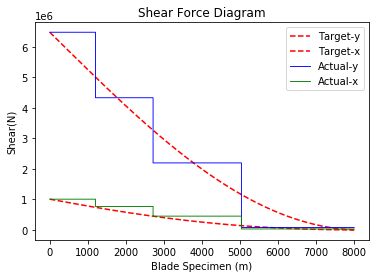

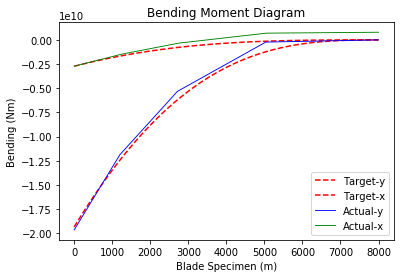

In [22]:
ActualSheary, ActualShearx = AcSh2D(n)
ActualBendingy, ActualBendingx = AcBe(ActualSheary, ActualShearx)

plt.plot(x, TargetSheary,'r', label = 'Target-y',ls='--')
plt.plot(x, TargetShearx,'r', label = 'Target-x',ls='--')
plt.step(x, ActualSheary,'b', label = 'Actual-y', where='post',lw=0.9)
plt.step(x, ActualShearx,'g', label = 'Actual-x', where='post',lw=0.9)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Blade Specimen (m)')
plt.ylabel('Shear(N)')
plt.title('Shear Force Diagram')
plt.legend(loc='best')
plt.savefig('ShearForceDiagram.png')
plt.show()


plt.plot(x,TargetBendingy, 'r', label = 'Target-y',ls='--')
plt.plot(x,TargetBendingx, 'r', label = 'Target-x',ls='--')
plt.plot(x, ActualBendingy, 'b', label = 'Actual-y',lw=0.9)
plt.plot(x, ActualBendingx, 'g', label = 'Actual-x',lw=0.9)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Blade Specimen (m)')
plt.ylabel('Bending (Nm)')
plt.title('Bending Moment Diagram')
plt.legend(loc='best')
plt.savefig('BendingMomentDiagram.png')
plt.show()

# Exporting to Excel

In [ ]:
#how to export solution of where rams are acting??? also need to change outputs for 2D

In [36]:
d = {'Nodes':x,'TargetShear':TargetShear,'ActualShear':ActualShear,'TargetBending':TargetBending,'ActualBending':ActualBending}
df = pd.DataFrame(data=d)
df.to_csv('newcsv.csv', index= False)

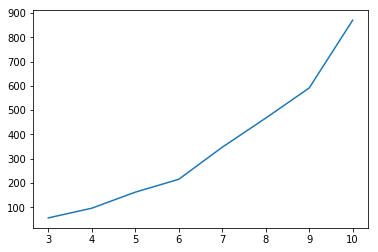

In [23]:
ramcount=[3, 4, 5, 6, 7, 8, 9, 10 ]
seconds=[56, 96, 162, 215, 347, 467, 591, 870 ]


fig, ax = plt.subplots()
ax.plot(ramcount, seconds)

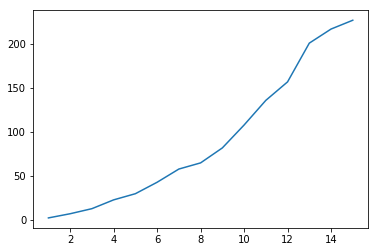

In [189]:
#when 1000 nodes are used (for 1 DDDDDDDDDDDDDD)
ramcount=[1,   2,   3,  4,  5,  6,   7,  8,  9,  10,  11, 12,  13,  14,   15 ]
seconds=[2.5, 7.25, 13, 23, 30, 43, 58, 65, 82, 108, 136, 157, 201, 217, 227]

fig, ax = plt.subplots()
ax.plot(ramcount, seconds)

In [129]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html